In [1]:
import torch
import torch.nn.functional as F
import model, utils
import transform as trans
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
import numpy as np

import cv2
import torchvision
import torch
import torchvision.transforms as transforms
# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
device = utils.get_device()
cuda = torch.cuda.is_available()
SEED = 42

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available:  True


In [3]:
## To get the std and mean value

import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the CIFAR-10 dataset
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
pixel_means = cifar10_train.data.mean(axis=(0,1,2)) / 255.0
pixel_stds = cifar10_train.data.std(axis=(0,1,2)) / 255.0

print('CIFAR-10 pixel means:', pixel_means)
print('CIFAR-10 pixel stds:', pixel_stds)
print(cifar10_train.data.shape)

Files already downloaded and verified
CIFAR-10 pixel means: [0.49139968 0.48215841 0.44653091]
CIFAR-10 pixel stds: [0.24703223 0.24348513 0.26158784]
(50000, 32, 32, 3)


In [4]:
class args():
    def __init__(self,device = 'cpu' ,use_cuda = False) -> None:
        self.batch_size = 128
        self.device = device
        self.use_cuda = use_cuda
        self.kwargs = {'num_workers': 1, 'pin_memory': True} if self.use_cuda else {}

In [5]:
train_transforms = trans.get_train_transforms(pixel_means, pixel_stds)
test_transforms = trans.get_test_transforms(pixel_means, pixel_stds)

trainset = trans.Cifar10SearchDataset(root='./data', train=True,
                                download=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args().batch_size,
                                          shuffle=True, **args().kwargs)

testset = trans.Cifar10SearchDataset(root='./data', train=False,
                               download=True, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(testset, batch_size=args().batch_size,
                                         shuffle=True, **args().kwargs)

Files already downloaded and verified
Files already downloaded and verified


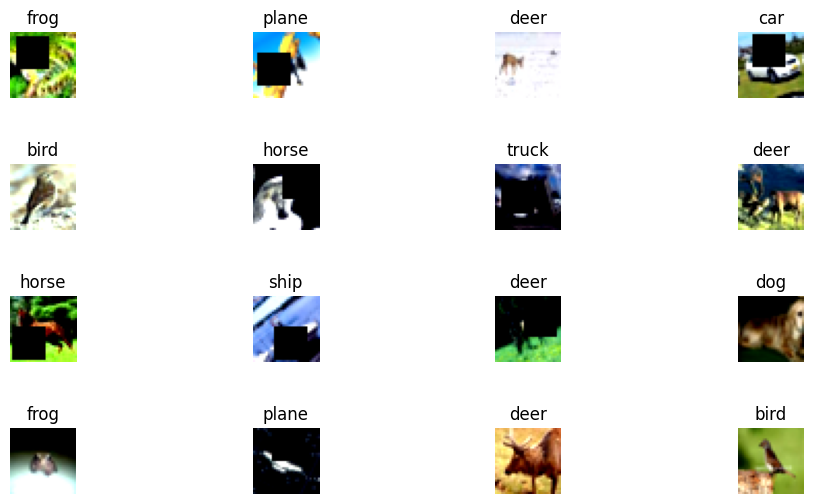

In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

utils.visualise_dataset(train_loader, classes)

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
cnnmodel = model.Net().to(device)
summary(cnnmodel, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,728
              ReLU-2           [-1, 64, 30, 30]               0
       BatchNorm2d-3           [-1, 64, 30, 30]             128
           Dropout-4           [-1, 64, 30, 30]               0
            Conv2d-5          [-1, 128, 28, 28]           2,304
              ReLU-6          [-1, 128, 28, 28]               0
       BatchNorm2d-7          [-1, 128, 28, 28]             256
           Dropout-8          [-1, 128, 28, 28]               0
            Conv2d-9           [-1, 64, 28, 28]           8,192
             ReLU-10           [-1, 64, 28, 28]               0
      BatchNorm2d-11           [-1, 64, 28, 28]             128
          Dropout-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 26, 26]           2,304
             ReLU-14          [-1,

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(cnnmodel.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

EPOCHS = 20
criterion = F.nll_loss
misclassified = []
actual_labels = []
predicted_labels = []

In [9]:
for epoch in range(1, EPOCHS+1):
  print(f'Epoch {epoch}')
  loss = model.train(cnnmodel, device, train_loader, criterion, optimizer, epoch)
  scheduler.step(loss)
  model.test(cnnmodel, device, test_loader)

Epoch 1


Loss=1.4837071895599365 Batch_id=390 Accuracy=46.27: 100%|██████████| 391/391 [01:47<00:00,  3.63it/s]



Test set: Average loss: 1.0578, Accuracy: 6185/10000 (61.85%)

Epoch 2


Loss=1.083159327507019 Batch_id=390 Accuracy=58.75: 100%|██████████| 391/391 [01:45<00:00,  3.69it/s]



Test set: Average loss: 0.8503, Accuracy: 7008/10000 (70.08%)

Epoch 3


Loss=1.0724537372589111 Batch_id=390 Accuracy=63.40: 100%|██████████| 391/391 [01:45<00:00,  3.70it/s]



Test set: Average loss: 0.7905, Accuracy: 7221/10000 (72.21%)

Epoch 4


Loss=0.9310222864151001 Batch_id=390 Accuracy=65.88: 100%|██████████| 391/391 [01:45<00:00,  3.70it/s]



Test set: Average loss: 0.6932, Accuracy: 7598/10000 (75.98%)

Epoch 5


Loss=0.8623763918876648 Batch_id=390 Accuracy=67.51: 100%|██████████| 391/391 [01:46<00:00,  3.67it/s]



Test set: Average loss: 0.6804, Accuracy: 7663/10000 (76.63%)

Epoch 6


Loss=0.7485002279281616 Batch_id=390 Accuracy=69.33: 100%|██████████| 391/391 [01:45<00:00,  3.69it/s]



Test set: Average loss: 0.6269, Accuracy: 7830/10000 (78.30%)

Epoch 7


Loss=0.9077650308609009 Batch_id=390 Accuracy=70.45: 100%|██████████| 391/391 [01:46<00:00,  3.66it/s]



Test set: Average loss: 0.5778, Accuracy: 8006/10000 (80.06%)

Epoch 8


Loss=0.9701915979385376 Batch_id=390 Accuracy=71.11: 100%|██████████| 391/391 [01:46<00:00,  3.66it/s]



Test set: Average loss: 0.5659, Accuracy: 8094/10000 (80.94%)

Epoch 9


Loss=0.863086998462677 Batch_id=390 Accuracy=71.71: 100%|██████████| 391/391 [01:45<00:00,  3.69it/s]


Epoch 00009: reducing learning rate of group 0 to 1.0000e-03.

Test set: Average loss: 0.5541, Accuracy: 8129/10000 (81.29%)

Epoch 10


Loss=0.7767266035079956 Batch_id=390 Accuracy=75.95: 100%|██████████| 391/391 [01:46<00:00,  3.68it/s]



Test set: Average loss: 0.4623, Accuracy: 8429/10000 (84.29%)

Epoch 11


Loss=0.4978834092617035 Batch_id=390 Accuracy=77.16: 100%|██████████| 391/391 [01:46<00:00,  3.68it/s]



Test set: Average loss: 0.4508, Accuracy: 8489/10000 (84.89%)

Epoch 12


Loss=0.5726671814918518 Batch_id=390 Accuracy=77.42: 100%|██████████| 391/391 [01:46<00:00,  3.67it/s]



Test set: Average loss: 0.4447, Accuracy: 8513/10000 (85.13%)

Epoch 13


Loss=0.5696507096290588 Batch_id=390 Accuracy=77.71: 100%|██████████| 391/391 [01:46<00:00,  3.67it/s]



Test set: Average loss: 0.4375, Accuracy: 8507/10000 (85.07%)

Epoch 14


Loss=0.6685494184494019 Batch_id=390 Accuracy=78.30: 100%|██████████| 391/391 [01:46<00:00,  3.66it/s]


Epoch 00014: reducing learning rate of group 0 to 1.0000e-04.

Test set: Average loss: 0.4311, Accuracy: 8538/10000 (85.38%)

Epoch 15


Loss=0.5498850345611572 Batch_id=390 Accuracy=79.15: 100%|██████████| 391/391 [01:46<00:00,  3.67it/s]



Test set: Average loss: 0.4251, Accuracy: 8557/10000 (85.57%)

Epoch 16


Loss=0.5072207450866699 Batch_id=390 Accuracy=79.04: 100%|██████████| 391/391 [01:46<00:00,  3.67it/s]



Test set: Average loss: 0.4245, Accuracy: 8555/10000 (85.55%)

Epoch 17


Loss=0.6806830167770386 Batch_id=390 Accuracy=79.07: 100%|██████████| 391/391 [01:46<00:00,  3.68it/s]


Epoch 00017: reducing learning rate of group 0 to 1.0000e-05.

Test set: Average loss: 0.4222, Accuracy: 8583/10000 (85.83%)

Epoch 18


Loss=0.7109628915786743 Batch_id=390 Accuracy=78.97: 100%|██████████| 391/391 [01:46<00:00,  3.68it/s]



Test set: Average loss: 0.4212, Accuracy: 8584/10000 (85.84%)

Epoch 19


Loss=0.4915342330932617 Batch_id=390 Accuracy=79.21: 100%|██████████| 391/391 [01:46<00:00,  3.67it/s]



Test set: Average loss: 0.4224, Accuracy: 8566/10000 (85.66%)

Epoch 20


Loss=0.6273964643478394 Batch_id=390 Accuracy=79.29: 100%|██████████| 391/391 [01:46<00:00,  3.66it/s]



Test set: Average loss: 0.4233, Accuracy: 8582/10000 (85.82%)



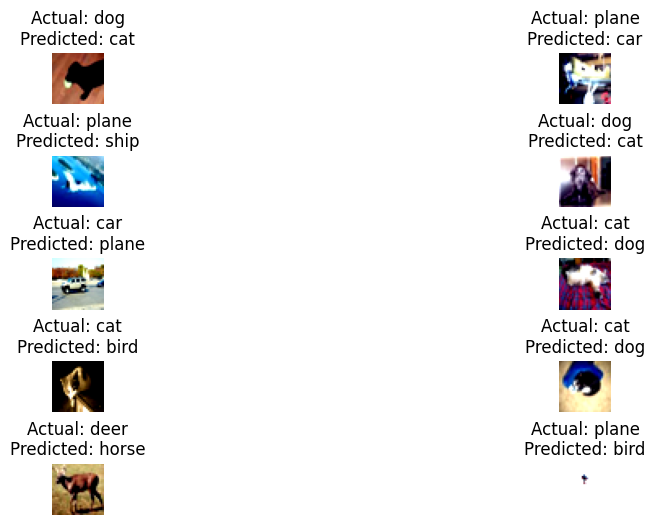

In [10]:
# To show the misclassified Images
model.plot_misclassifeid_images()

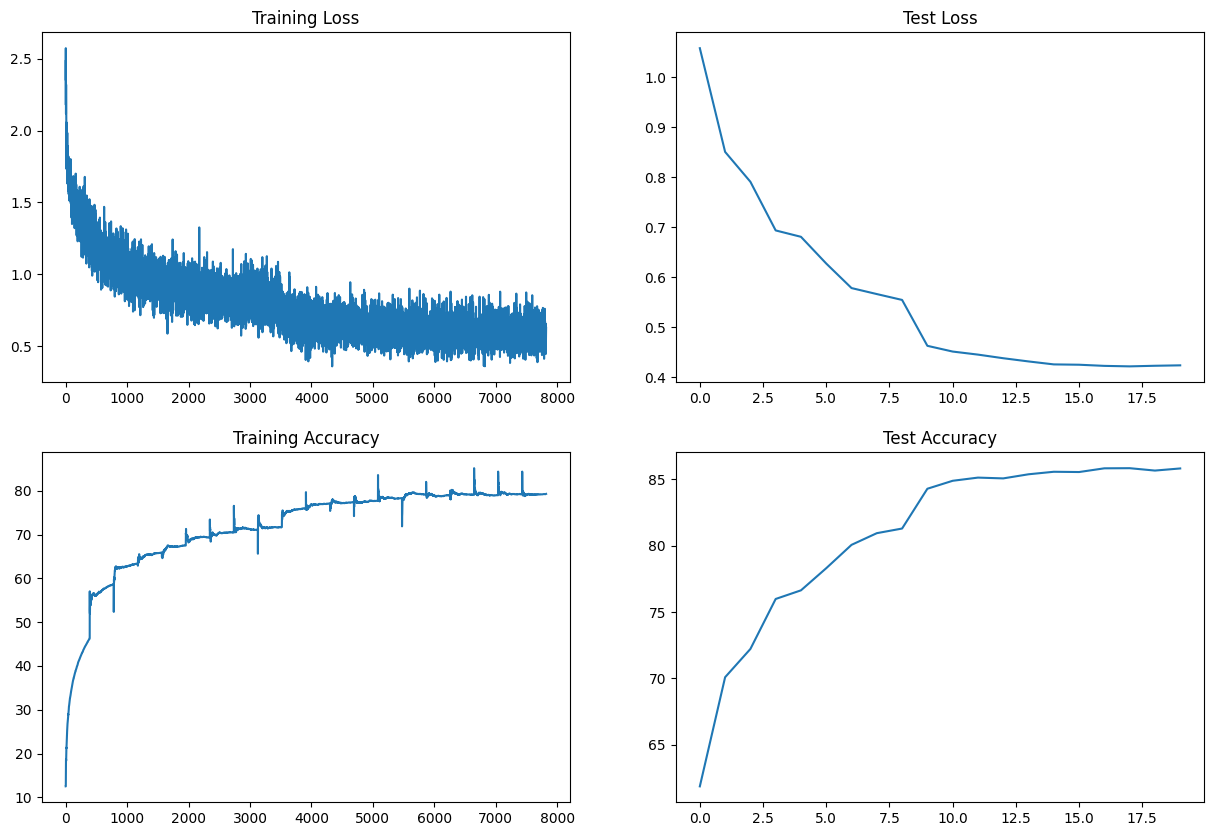

In [11]:
# Graph
model.plot_loss_accuracy_graph()